In [10]:
import torch
import torch.optim as optimizer
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms

In [11]:
data_path = './p1ch7'
tensor_cifar10 = datasets.CIFAR10(data_path,download=False,train = True,transform = transforms.ToTensor())
tensor_cifar10_val = datasets.CIFAR10(data_path,download=False,train = False,transform = transforms.ToTensor())


In [12]:
imgs = torch.stack([img_t for img_t,_ in tensor_cifar10],dim = 3)
imgs_val = torch.stack([img_t for img_t,_ in tensor_cifar10_val],dim = 3)
imgs_avg = imgs.view(3,-1).mean(1)
imgs_std = imgs.view(3,-1).std(1)
imgs_val_mean = imgs_val.view(3,-1).mean(1)
imgs_val_std = imgs_val.view(3,-1).std(1)


In [13]:
tensor_cifar10 = datasets.CIFAR10(data_path,download=False,train = True,transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = imgs_avg,std=imgs_std)
]))
tensor_cifar10_val = datasets.CIFAR10(data_path,download=False,train = False,transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = imgs_val_mean,std=imgs_val_std)
]))

In [14]:
label_map = {0:0,2:1}
cifar2 = [(img,label_map[label]) for img,label in tensor_cifar10 if label in [0,2]]
cifar2_val = [(img,label_map[label]) for img,label in tensor_cifar10_val if label in [0,2]]

In [15]:
conv = nn.Conv2d(3,16,kernel_size=3)
conv
img,_ = cifar2[0]
conv = nn.Conv2d(3,16,kernel_size=3,padding=1)
output = conv(img.unsqueeze(0))
output.shape


torch.Size([1, 16, 32, 32])

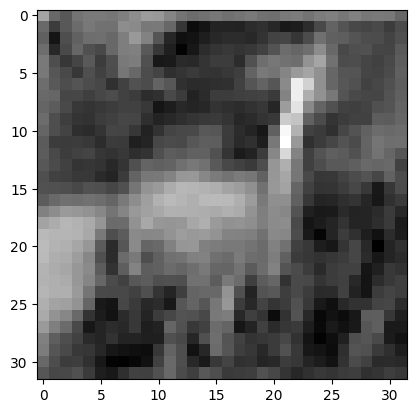

In [16]:
import matplotlib.pyplot as plt
plt.imshow(output[0,0].detach(),cmap='gray')

In [17]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
output.shape

torch.Size([1, 3, 16, 16])

In [18]:
model = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3,padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16,8,kernel_size=3,padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(8*8*8,32),
    nn.Tanh(),
    nn.Linear(32,2)
    
)

In [19]:
model(img.unsqueeze(0))

tensor([[ 0.1703, -0.1373]], grad_fn=<AddmmBackward0>)

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,padding=1)
        self.act2  =nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512,32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1,512)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [21]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0362,  0.0892]], grad_fn=<AddmmBackward0>)

In [22]:
import datetime

In [30]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
device = "cpu"

In [ ]:
def training_loop(model,loss_fn,optimizer,n_epoch,train_loader):
    for epoch in range(1,n_epoch+1):
        loss_train = 0
        for imgs,labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train+=loss.item()
        if epoch == 1 or epoch%10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(),epoch,loss_train/len(train_loader)))

train_loader = torch.utils.data.DataLoader(cifar2,batch_size=64,shuffle=True)
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(model,loss_fn,optimizer,100,train_loader)


2023-02-07 19:12:33.942968 Epoch 1, Training loss 0.5476619895476444
2023-02-07 19:12:48.755536 Epoch 10, Training loss 0.34535352297269617
2023-02-07 19:13:05.217358 Epoch 20, Training loss 0.3021829756581859
2023-02-07 19:13:21.712868 Epoch 30, Training loss 0.270555916532969
2023-02-07 19:13:38.322311 Epoch 40, Training loss 0.2472658750547725
2023-02-07 19:13:54.765424 Epoch 50, Training loss 0.22710281197622323
2023-02-07 19:14:11.268308 Epoch 60, Training loss 0.21094815395060618
2023-02-07 19:14:27.694363 Epoch 70, Training loss 0.19450363184616065


In [29]:
val_loader = torch.utils.data.DataLoader(cifar2_val,batch_size=64,shuffle=False)
train_loader = torch.utils.data.DataLoader(cifar2,batch_size=64,shuffle=False)
def validate(model,train_loader,val_loader):
    for name,loader in [("train",train_loader),("val",val_loader)]:
        total = 0
        correct = 0
        with torch.no_grad():
            for imgs,labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                _,predicted = torch.max(outputs,dim = 1)
                total+=labels.shape[0]
                correct+=int((predicted == labels).sum())
        print("Accuracy {}:{:.2f}".format(name,correct/total))
validate(model,train_loader,val_loader)
            

Accuracy train:0.50
Accuracy val:0.50


In [ ]:
torch.save(model.state_dict(),"birds_vs_airplanes.pt")

In [ ]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load("./birds_vs_airplanes.pt"))

In [ ]:
torch.cuda.is_available()

In [ ]:
import torch.functional as F

In [ ]:
class NetDepth(nn.Module):
    def __init__(self,nchans1=32):
        super().__init__()
        self.conv1 = nn.Conv2d(3,nchans1,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(nchans1,nchans1//2,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(nchans1//2,nchans1//2,kernel_size=3,padding=1)
        self.fc1 = nn.Linear(nchans1//2*4*4,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.F.max_pool2d(torch.relu(self.conv1(x)),2)
        out1 = out
        out = F.F.max_pool2d(torch.relu(self.conv2(out)),2)
        out = F.F.max_pool2d(torch.relu(self.conv3(out))+out1,2)
        out = out.view(-1,4*4*(self.nchans1//2))
        out = torch.relu(torch.fc1(out))
        out = self.fc2(out)

In [ ]:
class ResBlock(nn.Module):
    def __init__(self,n_chans):
        super().__init__()
        self.conv = nn.Conv2d(3,n_chans,kernel_size=3,padding=1,bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        nn.init.kaiming_normal_(self.conv.weight,nonlinearity='relu')
        nn.init.constant_(self.batch_norm.weight,0.5)
        nn.init.zeros_(self.batch_normatch_norm.bias)
    def forward(self,x):
        out = self.conv(x)
        out = self.batch_norm(x)
        out = torch.relu(out)
        return out+x
        
        

In [ ]:
class NetResDeep(nn.Module):
    def __init__(self,n_chans = 32,n_blocks = 10):
        super().__init__()
        self.nchans1 = n_chans
        self.conv1 = nn.Conv2d(3,n_chans,kernel_size=3,padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks*[ResBlock(n_chans=n_chans)])
        )
        self.fc1 = nn.Linear(8*8*n_chans,32)
        self.fc2 = nn.Linear(32,2)
    def forward(self,x):
        out = F.F.max_pool2d(torch.relu(self.conv1(x)),2)
        out = self.resblocks(out)
        out = F.F.max_pool2d(out,2)
        out = out.view(-1,8*8*self.nchans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    